In [1]:
from model import NARX
import torch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("data/maglev_data.csv", header = None, names = ["current", "position"])
df

,current,position
0,3.750646,0.500000
1,3.750646,0.506442
2,3.750646,0.525258
3,3.750646,0.555481
4,3.750646,0.595958
...,...,...
3996,1.199622,2.865977
3997,1.199622,2.860937
3998,1.199622,2.855380
3999,1.199622,2.849327


In [3]:
current_numpy = df["current"].to_numpy()
position_numpy = df["position"].to_numpy()

# scaling 
current_scaler = MinMaxScaler(feature_range=(0, 1))
position_scaler = MinMaxScaler(feature_range=(0, 1))

current_tensor = torch.tensor(
    current_scaler.fit_transform(current_numpy.reshape(-1, 1)),
    dtype=torch.float32
).unsqueeze(0) 

position_tensor = torch.tensor(
    position_scaler.fit_transform(position_numpy.reshape(-1, 1)), 
    dtype=torch.float32
).unsqueeze(0) 


print("Scaled Tensor Shapes:")
print(current_tensor.shape)
print(position_tensor.shape)

Scaled Tensor Shapes:
torch.Size([1, 4001, 1])
torch.Size([1, 4001, 1])


In [4]:
# train, validation, test
train_prop = 0.6
valid_prop = 0.2

sequence_length = current_tensor.shape[1]
n_train = int(train_prop * sequence_length)
n_val = int(valid_prop * sequence_length)
n_test = sequence_length - n_train - n_val 

split1 = n_train
split2 = n_train + n_val

# Training Set
train_current = current_tensor[:, :split1, :]
train_position = position_tensor[:, :split1, :]

# Validation Set
valid_current = current_tensor[:, split1:split2, :]
valid_position = position_tensor[:, split1:split2, :]

# Test Set
test_current = current_tensor[:, split2:, :]
test_position = position_tensor[:, split2:, :]

# PARALLEL TRAIN ARCHITECTURE

In [5]:
model = NARX(d_i = 50, d_o = 50, d_x = 1, d_y = 1, d_hl = 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr = 0.001, params = model.parameters())

EPOCHS = 1000
PATIENCE = 5

best_MSE = None
patience = None

train_loss_history = []
valid_loss_history = []

for i in range(EPOCHS):
    # training
    model.train()
    y_pred = model(train_current)
    loss = loss_fn(train_position, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_history.append(loss.item())

    # validation
    model.eval()
    with torch.no_grad():
        y_pred = model(valid_current)
        loss = loss_fn(valid_position, y_pred)

        print(f"BCE validation loss at epoch {i}: {loss.item()}")
        valid_loss_history.append(loss.item())

        if best_MSE is None or loss.item() < best_MSE:
            best_MSE = loss.item()
            patience = PATIENCE
        
        else:
            patience -= 1
            if patience == 0:
                break

BCE validation loss at epoch 0: 0.10029176622629166
BCE validation loss at epoch 1: 0.09927385300397873
BCE validation loss at epoch 2: 0.0983654037117958
BCE validation loss at epoch 3: 0.09755679965019226
BCE validation loss at epoch 4: 0.09683836251497269
BCE validation loss at epoch 5: 0.09620101004838943
BCE validation loss at epoch 6: 0.09563658386468887
BCE validation loss at epoch 7: 0.09513796120882034
BCE validation loss at epoch 8: 0.09469886869192123
BCE validation loss at epoch 9: 0.09431379288434982
BCE validation loss at epoch 10: 0.0939776599407196
BCE validation loss at epoch 11: 0.09368576854467392
BCE validation loss at epoch 12: 0.093433678150177
BCE validation loss at epoch 13: 0.09321703016757965
BCE validation loss at epoch 14: 0.09303168952465057
BCE validation loss at epoch 15: 0.09287357330322266
BCE validation loss at epoch 16: 0.09273871779441833
BCE validation loss at epoch 17: 0.09262330085039139
BCE validation loss at epoch 18: 0.09252374619245529
BCE val

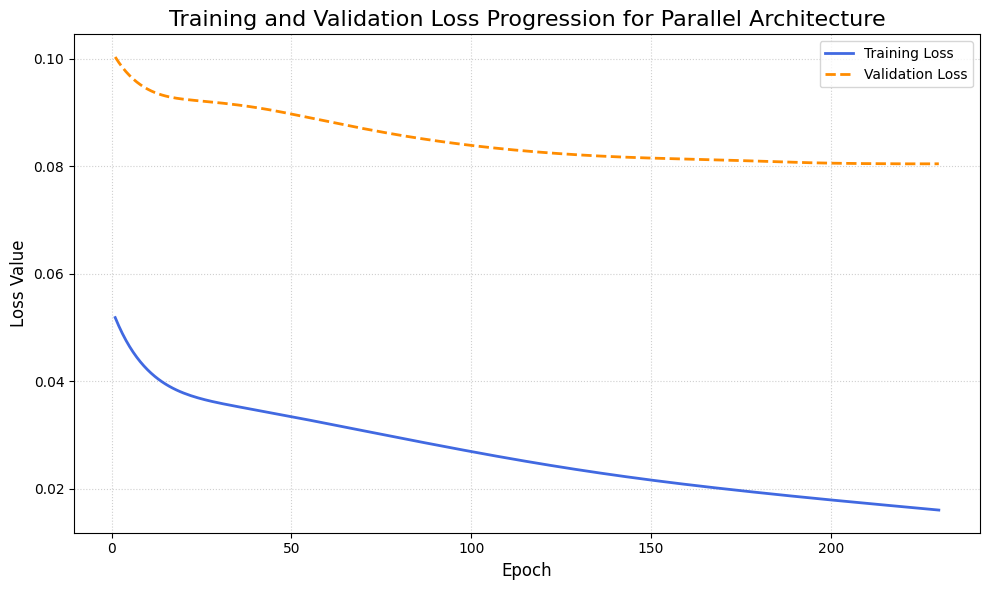

In [6]:
num_epochs = len(train_loss_history)
epoch_axis = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epoch_axis, train_loss_history, label='Training Loss', color='royalblue', linewidth=2)
plt.plot(epoch_axis, valid_loss_history, label='Validation Loss', color='darkorange', linestyle='--', linewidth=2)

plt.title('Training and Validation Loss Progression for Parallel Architecture', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

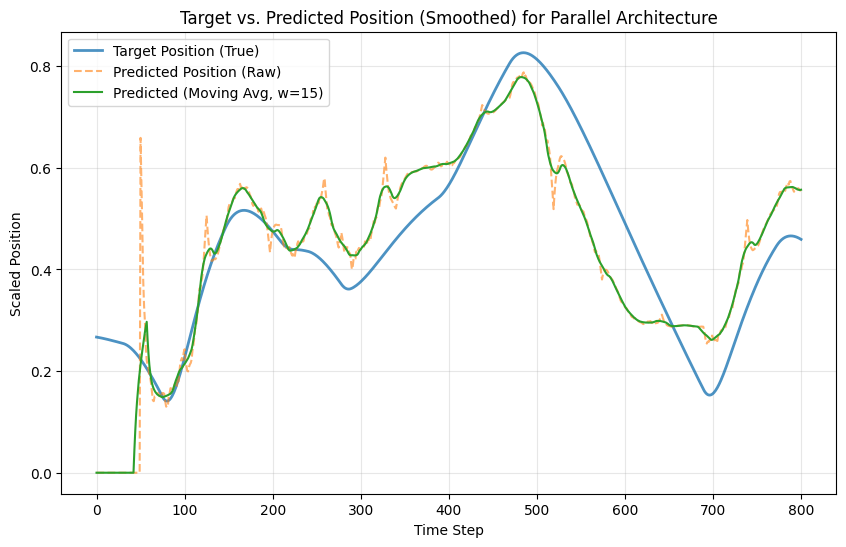

In [7]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    y_pred = model(test_current) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# SERIES-PARALLEL TRAIN ARCHITECTURE

In [8]:
model = NARX(d_i = 50, d_o = 50, d_x = 1, d_y = 1, d_hl = 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr = 0.001, params = model.parameters())

EPOCHS = 1000
PATIENCE = 5

best_MSE = None
patience = None

train_loss_history = []
valid_loss_history = []

for i in range(EPOCHS):
    # training
    model.train()
    y_pred = model(train_current, train_position)
    loss = loss_fn(train_position, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_history.append(loss.item())

    # validation
    model.eval()
    with torch.no_grad():
        y_pred = model(valid_current, valid_position)
        loss = loss_fn(valid_position, y_pred)

        print(f"BCE validation loss at epoch {i}: {loss.item()}")
        valid_loss_history.append(loss.item())

        if best_MSE is None or loss.item() < best_MSE:
            best_MSE = loss.item()
            patience = PATIENCE
        
        else:
            patience -= 1
            if patience == 0:
                break

BCE validation loss at epoch 0: 0.09800126403570175
BCE validation loss at epoch 1: 0.09596405923366547
BCE validation loss at epoch 2: 0.0941125899553299
BCE validation loss at epoch 3: 0.09241683036088943
BCE validation loss at epoch 4: 0.09086401015520096
BCE validation loss at epoch 5: 0.08945486694574356
BCE validation loss at epoch 6: 0.08819343894720078
BCE validation loss at epoch 7: 0.08707498759031296
BCE validation loss at epoch 8: 0.08608037233352661
BCE validation loss at epoch 9: 0.085181824862957
BCE validation loss at epoch 10: 0.08435555547475815
BCE validation loss at epoch 11: 0.08358880877494812
BCE validation loss at epoch 12: 0.08287691324949265
BCE validation loss at epoch 13: 0.08221583068370819
BCE validation loss at epoch 14: 0.08159735053777695
BCE validation loss at epoch 15: 0.08100835978984833
BCE validation loss at epoch 16: 0.08043278753757477
BCE validation loss at epoch 17: 0.07985523343086243
BCE validation loss at epoch 18: 0.07926525920629501
BCE va

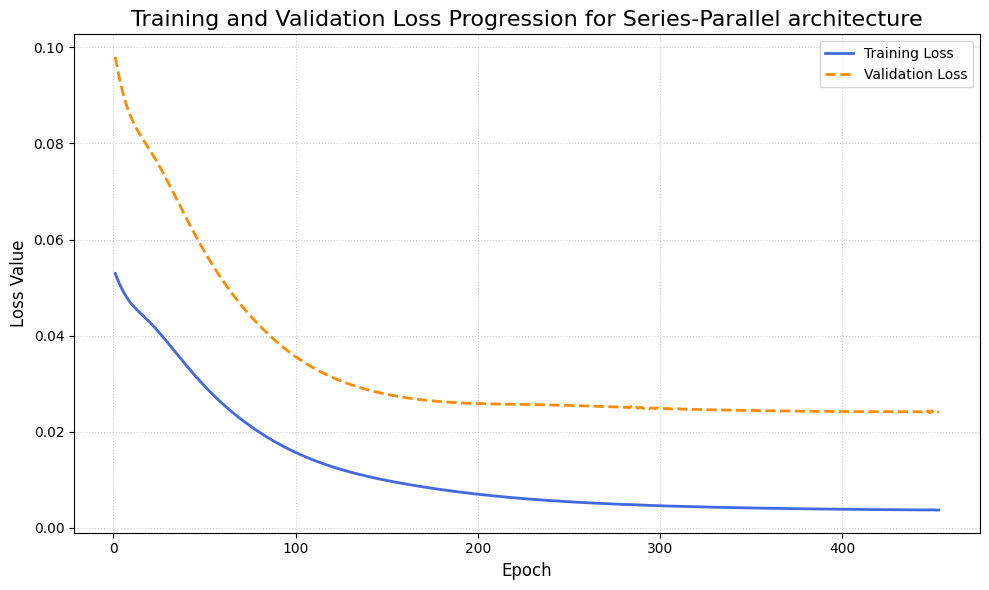

In [9]:
num_epochs = len(train_loss_history)
epoch_axis = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epoch_axis, train_loss_history, label='Training Loss', color='royalblue', linewidth=2)
plt.plot(epoch_axis, valid_loss_history, label='Validation Loss', color='darkorange', linestyle='--', linewidth=2)

plt.title('Training and Validation Loss Progression for Series-Parallel architecture', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

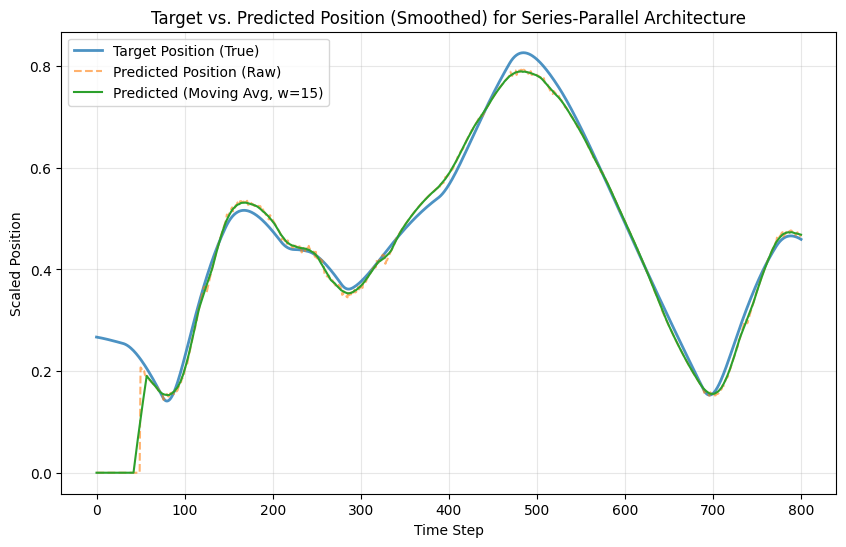

In [10]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    y_pred = model(x = test_current, y = test_position) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Series-Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

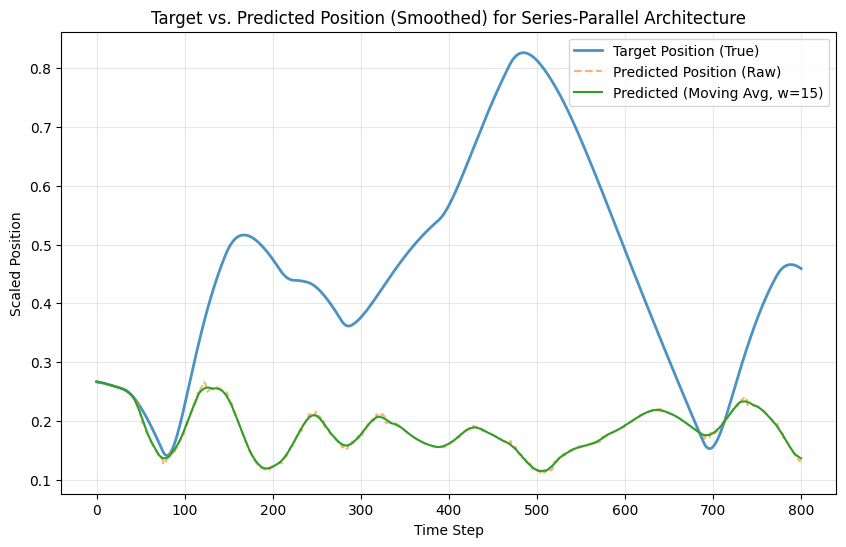

In [18]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    y_pred = model(test_current, y = test_position, bootstrap = 50) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Series-Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

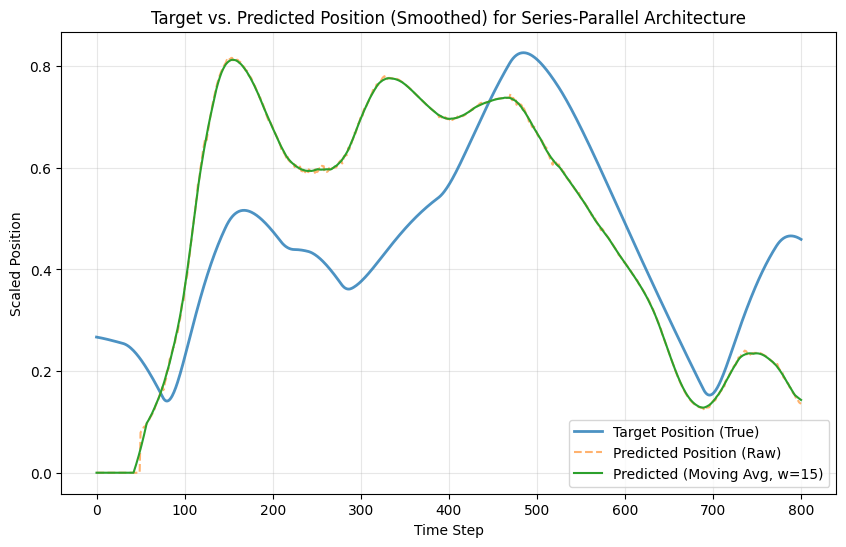

In [15]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    y_pred = model(test_current) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Series-Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()